In [1]:
from subprocess import call
import os
import patsy
import folium as folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import Image
from matplotlib import pyplot
from numpy import isnan
from patsy.highlevel import dmatrices, dmatrix
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.impute import KNNImputer
from sklearn.impute._iterative import IterativeImputer
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

读取数据集

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, doublequote=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)

header = None即指明原始文件数据没有列索引，这样read_csv为自动加上列索引，除非你给定列索引的名字。

In [2]:
root = 'D:\deep_learning\datasets\hose_predict'
file_name = 'housing.csv'
file_path = os.path.join(root,file_name)
data = pd.read_csv(file_path,delimiter=',')#读取数据集
data_copy = data.copy()

In [3]:
data_copy.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


pipeline

In [4]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


补充缺失值

In [5]:
data_copy.isnull().sum()

longitude             0  
latitude              0  
housing_median_age    0  
total_rooms           0  
total_bedrooms        207
population            0  
households            0  
median_income         0  
median_house_value    0  
ocean_proximity       0  
dtype: int64

In [6]:
data_copy['total_bedrooms'] = data_copy['total_bedrooms'].fillna(method='ffill')
data_copy.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

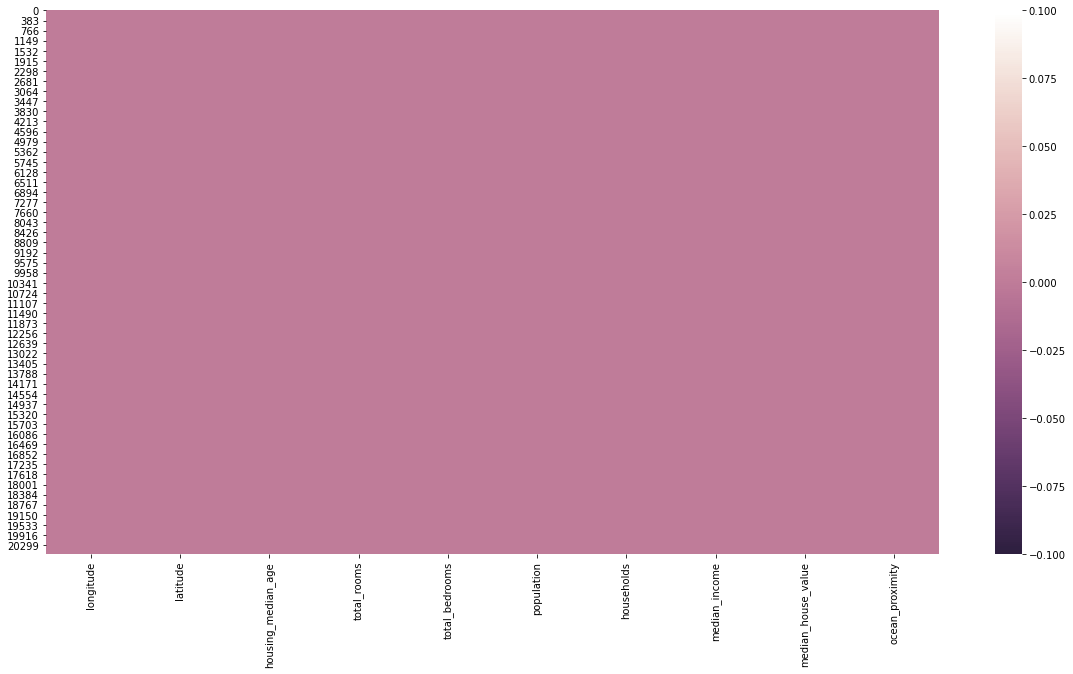

In [7]:
#%matplotlib inline
_ = plt.figure(figsize=(20, 10))

# cubehelix palette is a part of seaborn that produces a colormap
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
_ = sns.heatmap(data_copy.isnull(), cmap=cmap)

https://www.geeksforgeeks.org/how-to-make-histograms-with-density-plots-with-seaborn-histplot/

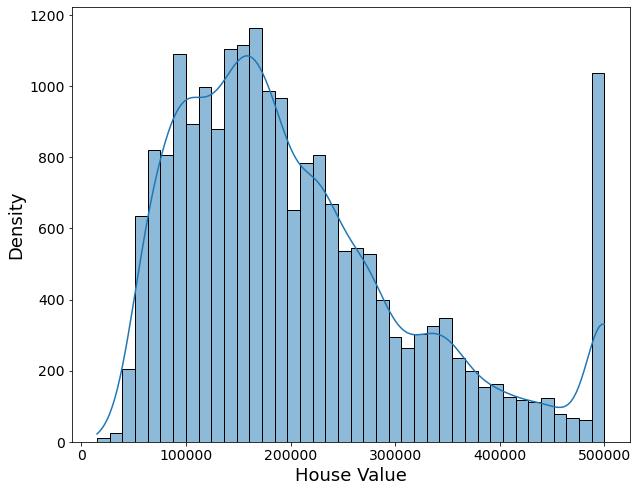

In [8]:
# Continuous density plot
fig_missing, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot frequency plot/ histogram
_ = sns.histplot(x="median_house_value", kde=True, data=data_copy, ax=axes, bins=40);
_ = axes.set(xlabel="House Value", ylabel='Density');
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
axes.tick_params('y', labelsize = 14);
axes.tick_params('x', labelsize = 14);

In [9]:
print(data_copy['median_house_value'].describe())

count    20640.000000 
mean     206855.816909
std      115395.615874
min      14999.000000 
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64


In [11]:
all_x = list(data_copy.columns.values)
print(all_x)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [12]:
reg_x = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
cls_x = ['ocean_proximity']
data_for_reg = data_copy.loc[:,reg_x]#只有数字的
data_for_cls = data_copy.loc[:,cls_x]#可以通过one-hot编码把他数字
data_for_cls.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [22]:
data_for_cls.value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND             5   
dtype: int64

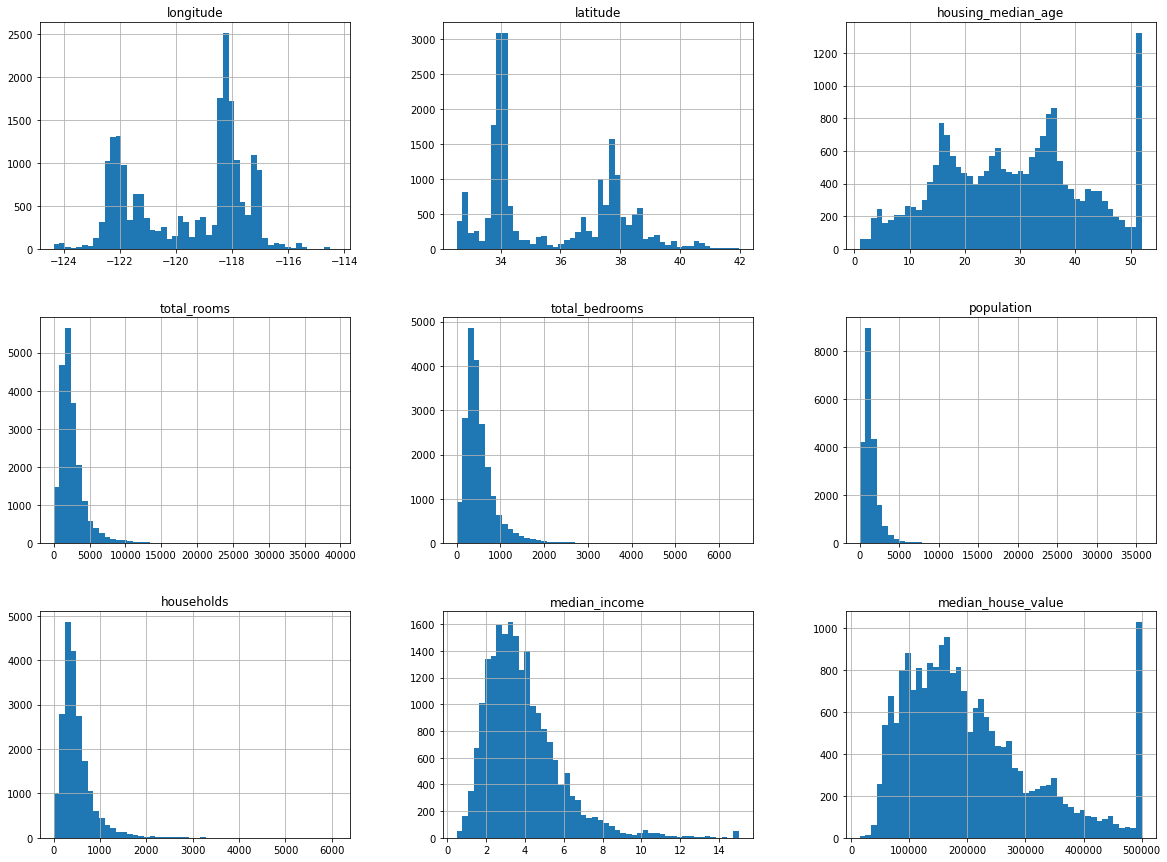

In [13]:
_ = data_copy.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
corr = data_copy.corr()
corr.sort_values(["median_house_value"], ascending = False, inplace = True)
print(corr.median_house_value)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049294
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


<Figure size 432x288 with 0 Axes>

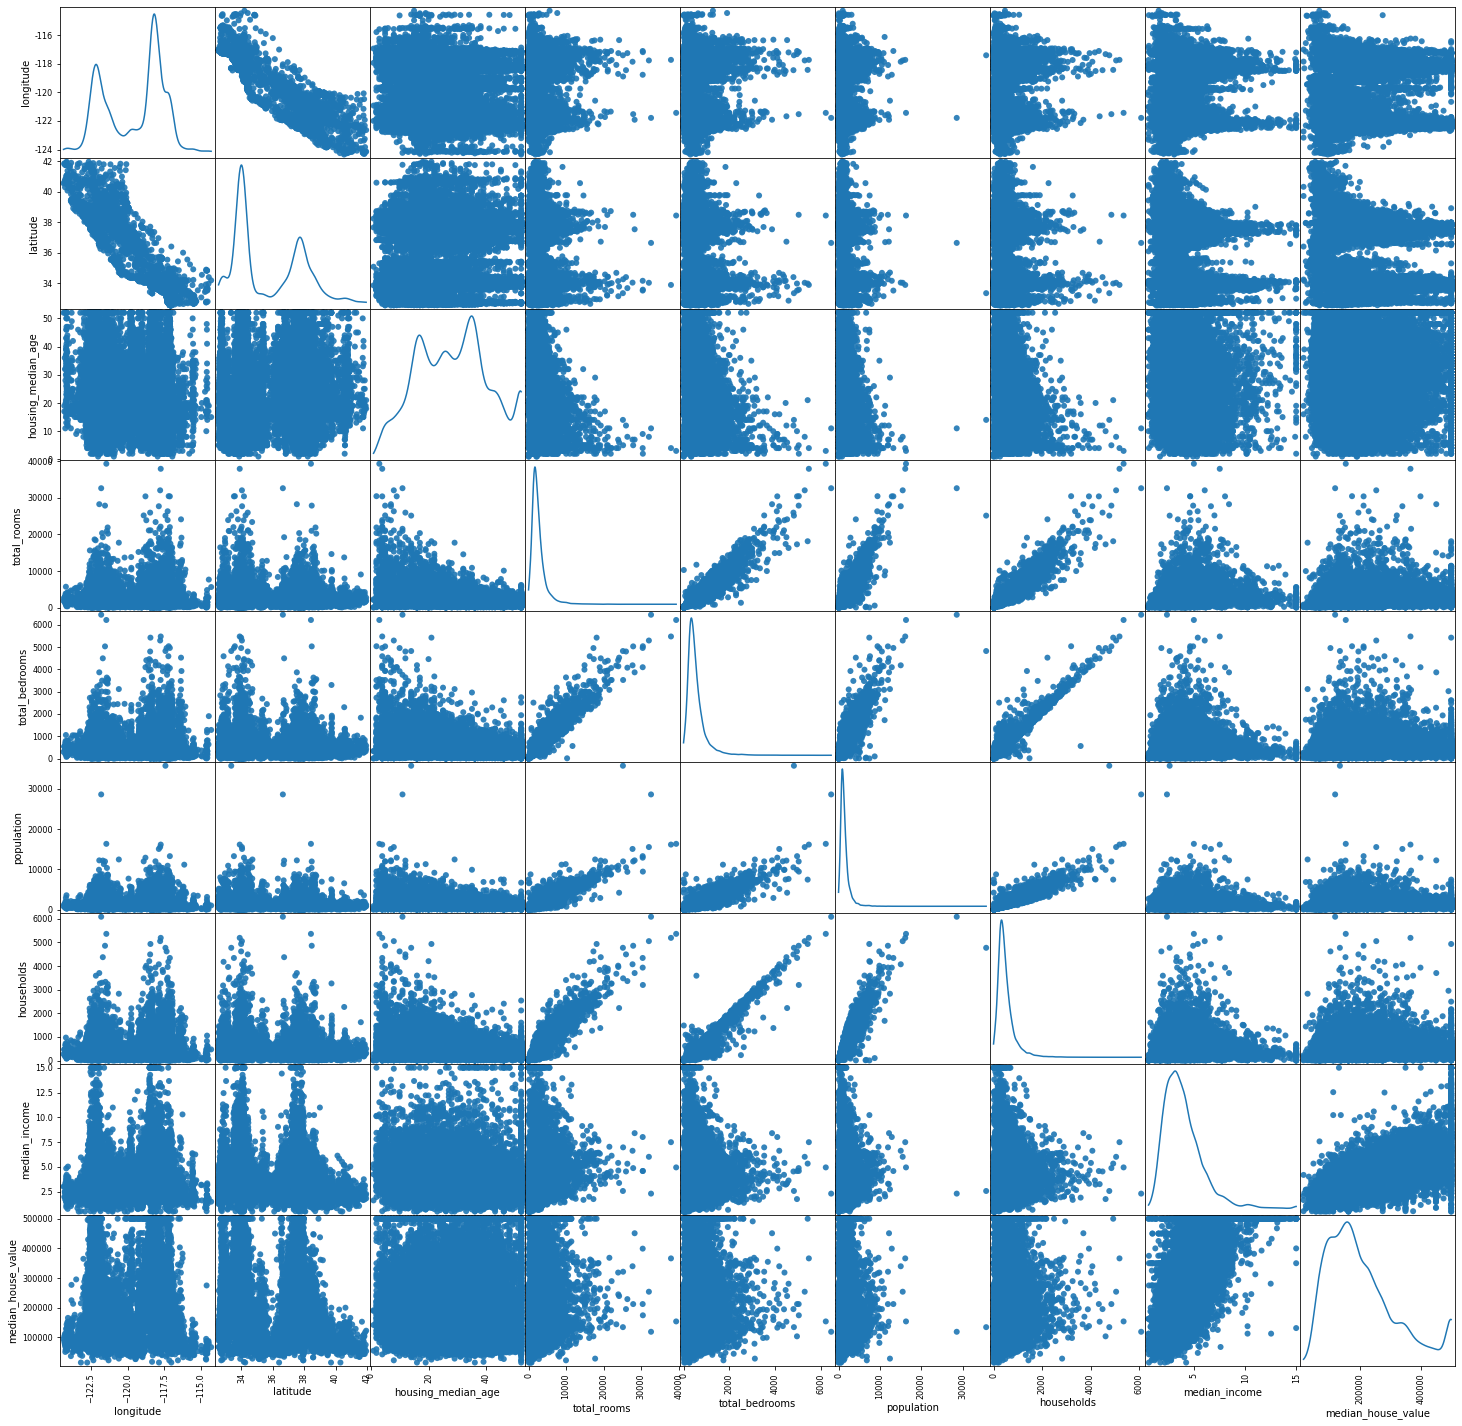

In [15]:
fig = plt.figure();
_ = scatter_matrix(data_for_reg, figsize = (25,25), alpha=0.9, diagonal="kde", marker="o");

In [16]:
e_X_label = ['median_income', 'housing_median_age']#['longitude', 'latitude', 'housing_median_age']
e_X = data_for_reg.loc[:,e_X_label]
e_Y = data_copy['median_house_value']

准备模型训练

In [17]:
model = LinearRegression(normalize = True)
X_train, X_test, y_train, y_test = train_test_split(e_X, e_Y, random_state=2)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15480, 2)
(15480,)
(5160, 2)
(5160,)


In [19]:
model_pred = model.fit(X_train,y_train)

In [20]:
model_coef = model_pred.coef_
print(model_pred.coef_)

[43246.84924584  1723.89330789]


In [21]:
y_pred = model_pred.predict(X_test)

In [22]:
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)

In [23]:
scoring =  'neg_mean_squared_error'
results = model_selection.cross_val_score(model_pred, e_X, e_Y, cv=kfold, scoring=scoring)
acc = model_selection.cross_val_score(model_pred, e_X, e_Y, cv=kfold)
print("MSE: %.3f (%.3f)" % (results.mean(), results.std()))
print(acc)

MSE: -6538365733.486 (403981855.504)
[0.51085373 0.49670246 0.52271746 0.47253555 0.53092344 0.4830377
 0.51306599 0.50783479 0.54503535 0.50820025]


<Figure size 720x432 with 0 Axes>

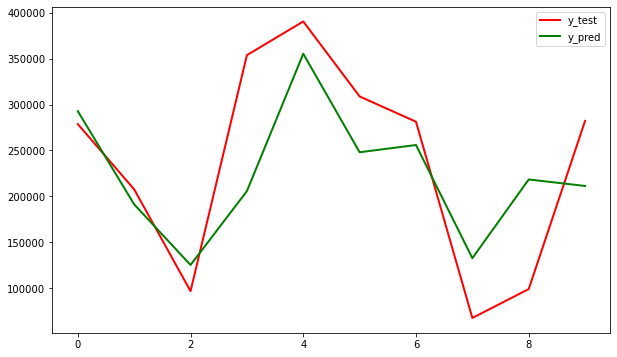

In [25]:
plt.figure(figsize=(10, 6))
t = np.arange(10)
plt.plot(t, y_test[0:10], 'r', linewidth=2, label='y_test')
plt.plot(t, y_pred[0:10], 'g', linewidth=2, label='y_pred')
plt.legend() 
plt.show()

In [26]:
y_test = np.array(y_test)

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'x')

Text(0, 0.5, 'house price')

[]

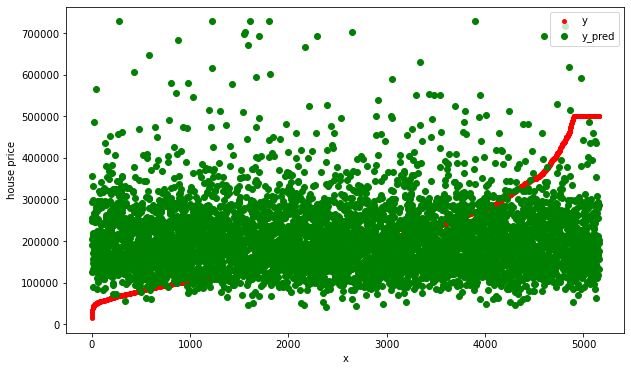

In [27]:
t=np.arange(0,len(y_test))
res=np.argsort(y_pred)
y_test_copy= [y_test[i] for i in res]
y_test_copy.sort()
plt.figure(figsize=(10, 6))
plt.scatter(t, y_test_copy, s=60, c='red', marker='.', alpha=1)
plt.scatter(t, y_pred, c='green')
plt.xlabel('x')
plt.ylabel('house price')
plt.legend(['y','y_pred'])
plt.plot()